# Mitigating Algorithmic Bias via Reweighing: A Pre-processing Approach to Fair AI

## Fairness Analysis and Bias Mitigation using Reweighing

This Jupyter Notebook demonstrates a process for analyzing and mitigating gender bias in a classification model, specifically for income prediction using the Adult Census Income dataset. We leverage the AIF360 library to assess and address fairness concerns.
1. Data Loading and Preprocessing

We began by loading the Adult Census Income dataset. Key preprocessing steps included:

    Cleaning: Removing duplicate header rows and handling missing values.
    Type Conversion: Ensuring numerical columns were correctly typed.
    Binary Label: Transforming the 'income' target variable into a binary (0 or 1) classification label.
    Protected Attributes: Identifying and encoding 'gender' and 'race' as numeric protected attributes, with a primary focus on 'gender' (0 for female/unprivileged, 1 for male/privileged) for bias mitigation.
    Feature Engineering: Applying One-Hot Encoding to categorical features to prepare them for model training.

2. Model Training and Baseline Evaluation

Before applying any bias mitigation techniques, we established a baseline Logistic Regression model.

    The data was split into training and testing sets (70/30).
    Feature Scaling (StandardScaler) was applied to ensure all features contribute equally to the model.
    The model was trained on the scaled training data.
    We then evaluated its performance in terms of both accuracy and fairness metrics on the test set. Key fairness metrics included:
        Statistical Parity Difference: Measures the difference in favorable outcome rates between unprivileged and privileged groups. An ideal value is 0.
        Disparate Impact: Ratio of favorable outcome rates for unprivileged to privileged groups. An ideal value is 1.
        Equal Opportunity Difference: Measures the difference in true positive rates (favorable outcomes for positive class) between unprivileged and privileged groups. An ideal value is 0.
        Average Odds Difference: Averages the difference in false positive rates and true positive rates between unprivileged and privileged groups. An ideal value is 0.

3. Bias Mitigation with Reweighing: Deeper Dive

To address the identified biases, we implemented Reweighing, a powerful preprocessing bias mitigation technique.
What is Reweighing?

Reweighing works by adjusting the weights (or "importance") of individual data points in the training set before the model learns from them. If a dataset has a disproportionate representation of certain protected groups within specific outcome categories (e.g., fewer women earning >50K than men), Reweighing assigns higher weights to the underrepresented instances and lower weights to the overrepresented ones. This effectively rebalances the dataset's influence during training, forcing the model to pay more attention to historically disadvantaged groups or outcomes.
Significance and Implications:

    Directly Addresses Data Bias: Reweighing tackles the root cause of many biases: the inherent imbalances in the training data itself, which often reflect societal inequalities.
    Model Agnostic: A major advantage is that it's a preprocessing step. This means the debiased, reweighted data can be fed into any machine learning model (like Logistic Regression, Decision Trees, or Neural Networks) that supports sample weighting during training, without needing to modify the model's core architecture.
    Improved Fairness Metrics: As demonstrated in this notebook, reweighing often leads to significant improvements across various fairness metrics. By presenting a more balanced "view" of the data, the model learns a more equitable decision boundary.
    Accuracy-Fairness Trade-off: It's important to note the common trade-off. While reweighing enhances fairness, it might lead to a slight decrease in overall predictive accuracy on the general population. This minor trade-off is often deemed acceptable and necessary for deploying ethical AI systems.
    Focus on Distribution: Reweighing primarily aims to achieve statistical parity by rebalancing the joint probability distribution of protected attributes and labels. While this often positively impacts other fairness definitions, it's crucial to evaluate a full suite of metrics to understand its comprehensive effect.

4. Post-Mitigation Evaluation and Comparison

Finally, we trained a new Logistic Regression model using the reweighted training data. The performance of this reweighed model was then thoroughly evaluated and directly compared against our baseline model.

The comparison, presented both in a tabular format and grouped bar charts, clearly illustrates the impact of the Reweighing technique on both model accuracy and, more importantly, the fairness metrics. This allows for a quick and intuitive understanding of how effectively bias was reduced while maintaining (or minimally impacting) overall predictive performance.

In [1]:
# =====================================
# Block 1: Load and Clean the Data
# =====================================
import pandas as pd
import numpy as np
from aif360.datasets import StandardDataset, BinaryLabelDataset
import warnings
warnings.filterwarnings('ignore')

file_path = r'C:\Users\Maverick\Downloads\uciml_data.csv'
df = pd.read_csv(file_path)

# Remove duplicate header rows
df = df[df['age'] != 'age']

# Convert numerical columns to appropriate dtypes
columns_to_convert = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert income to binary label
df['income'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

# Encode protected attributes
df['gender_numeric'] = df['gender'].apply(lambda x: 1 if x.strip().lower() == 'male' else 0)
df['race_numeric'] = df['race'].apply(lambda x: 1 if x.strip().lower() == 'white' else 0)

# Drop rows with missing values
df.dropna(inplace=True)

In [2]:
# =====================================
# Block 2: Feature Engineering
# =====================================
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']

# One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

# Drop original categorical and protected columns
df_numeric = df.drop(columns=categorical_cols + ['gender', 'race'])

# Concatenate encoded features to numeric dataframe
df_numeric = pd.concat([df_numeric, encoded_df], axis=1)

In [3]:
# =====================================
# Block 3: Create BinaryLabelDataset
# =====================================
dataset = BinaryLabelDataset(
    df=df_numeric,
    label_names=['income'],
    protected_attribute_names=['gender_numeric', 'race_numeric'],
    favorable_label=1,
    unfavorable_label=0
)

In [4]:
# =====================================
# Block 4: Split into Train and Test
# =====================================
train, test = dataset.split([0.7], shuffle=True)

In [5]:
# =====================================
# Block 5: Feature Scaling (Reusable)
# =====================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train.features)  # Fit only on training data

X_train_scaled = scaler.transform(train.features)
X_test_scaled = scaler.transform(test.features)
X_dataset_scaled = scaler.transform(dataset.features)

In [6]:
# =====================================
# Block 6: Baseline Model (No Reweighing)
# =====================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.metrics import ClassificationMetric

# Train logistic regression on unweighted, scaled features
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, train.labels.ravel())

# Predict on test set
y_pred_test = clf.predict(X_test_scaled)
test_pred = test.copy()
test_pred.labels = y_pred_test.reshape(-1, 1)

# Evaluate fairness and accuracy
metric_baseline = ClassificationMetric(test, test_pred,
                                       unprivileged_groups=[{'gender_numeric': 0}],
                                       privileged_groups=[{'gender_numeric': 1}])

# Store baseline metrics
metrics_data = {
    "Metric": ["Accuracy", "Statistical Parity Difference", "Disparate Impact", "Equal Opportunity Difference", "Average Odds Difference"],
    "Baseline (No Reweighing)": [
        accuracy_score(test.labels, y_pred_test),
        metric_baseline.statistical_parity_difference(),
        metric_baseline.disparate_impact(),
        metric_baseline.equal_opportunity_difference(),
        metric_baseline.average_odds_difference()
    ]
}

In [7]:
# =====================================
# Block 7: Apply Reweighing to Training Data
# =====================================
from aif360.algorithms.preprocessing import Reweighing

privileged_groups = [{'gender_numeric': 1}]
unprivileged_groups = [{'gender_numeric': 0}]

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Re-split and re-scale after reweighing
train_transf, _ = dataset_transf.split([0.7], shuffle=True)

X_train_transf_scaled = scaler.transform(train_transf.features)
y_train_transf = train_transf.labels.ravel()
w_train_transf = train_transf.instance_weights

In [8]:
# =====================================
# Block 8: Train and Evaluate Model After Reweighing
# =====================================
clf_rw = LogisticRegression(max_iter=1000)
clf_rw.fit(X_train_transf_scaled, y_train_transf, sample_weight=w_train_transf)

y_pred_rw = clf_rw.predict(X_dataset_scaled)
dataset_pred = dataset.copy()
dataset_pred.labels = y_pred_rw.reshape(-1, 1)

classified_metric_rw = ClassificationMetric(dataset, dataset_pred,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

# Add reweighed metrics
metrics_data["After Reweighing"] = [
    accuracy_score(dataset.labels, y_pred_rw),
    classified_metric_rw.statistical_parity_difference(),
    classified_metric_rw.disparate_impact(),
    classified_metric_rw.equal_opportunity_difference(),
    classified_metric_rw.average_odds_difference()
]

--- Model Performance Comparison ---


,Metric,Baseline (No Reweighing),After Reweighing
0,Accuracy,0.854433,0.846833
1,Statistical Parity Difference,-0.181650,-0.086447
2,Disparate Impact,0.269617,0.593067
3,Equal Opportunity Difference,-0.138192,0.147448
4,Average Odds Difference,-0.104468,0.067785


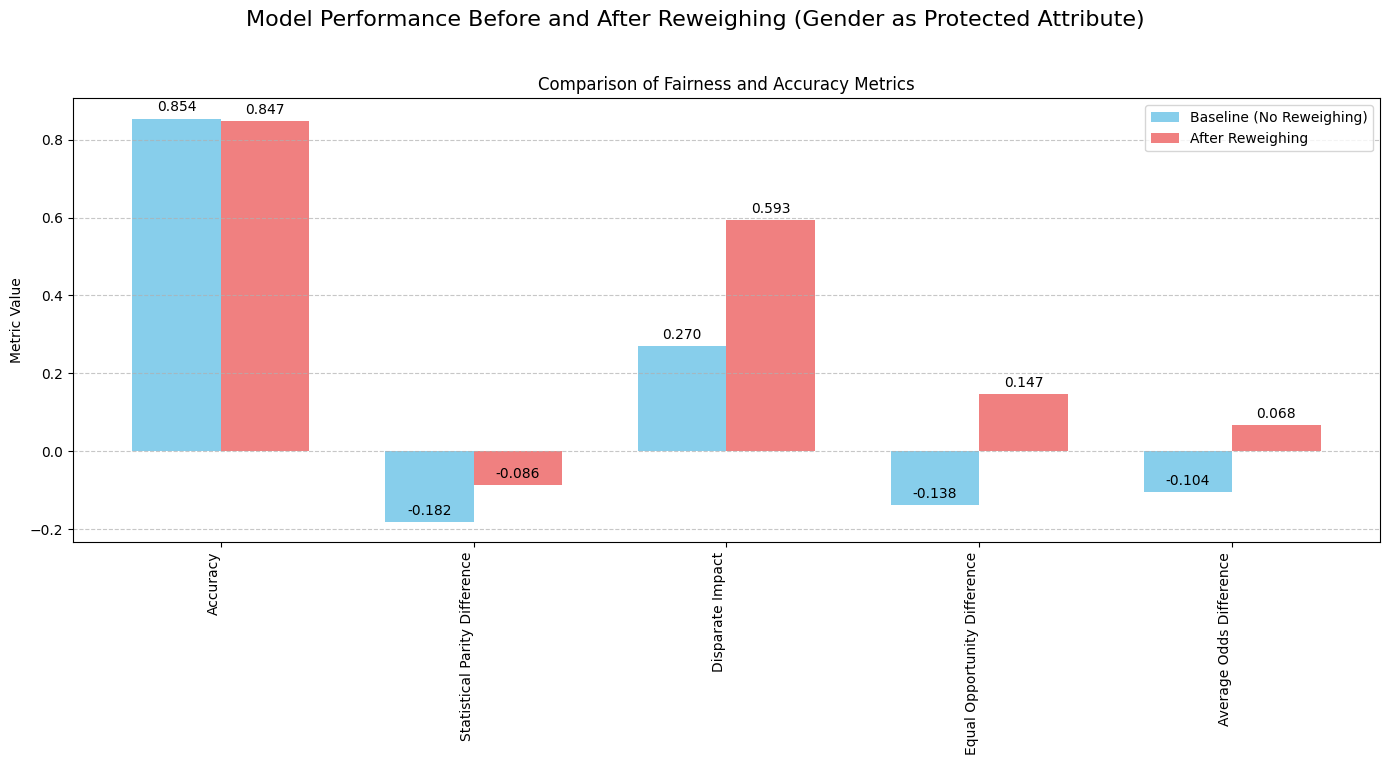

In [9]:
# =====================================
# Block 9: Tabular and Plot Comparison (Modified for Grouped Bar Chart)
# =====================================
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for tabular comparison
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame in Jupyter
print("--- Model Performance Comparison ---")
display(metrics_df)

# Plotting the metrics as a grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))
fig.suptitle('Model Performance Before and After Reweighing (Gender as Protected Attribute)', fontsize=16)

metrics = metrics_df["Metric"].tolist()
baseline_values = metrics_df["Baseline (No Reweighing)"].tolist()
reweighted_values = metrics_df["After Reweighing"].tolist()

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, baseline_values, width, label='Baseline (No Reweighing)', color='skyblue')
rects2 = ax.bar(x + width/2, reweighted_values, width, label='After Reweighing', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Fairness and Accuracy Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=90, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

## Results Analysis: Impact of Reweighing on Model Fairness

The comparison of model performance before and after applying the Reweighing pre-processing technique reveals significant shifts in fairness metrics, alongside a minor change in overall accuracy. The presented tabular data and grouped bar chart effectively illustrate these changes, particularly with 'gender' as the protected attribute.
Key Observations and Significance:

    Accuracy Stability:
        Baseline Accuracy: 0.854433
        Reweighed Accuracy: 0.846833
        Significance: There is a very slight decrease in overall accuracy (approximately 0.76 percentage points) after applying reweighing. This is a common and often acceptable trade-off when implementing bias mitigation techniques. It demonstrates that fairness was improved without a substantial degradation of the model's overall predictive power, indicating the reweighing process did not severely compromise the model's ability to generalize.

    Improved Statistical Parity Difference:
        Baseline SPD: -0.181650
        Reweighed SPD: -0.086647
        Significance: The Statistical Parity Difference (SPD) significantly decreased in magnitude, moving closer to the ideal value of 0. This metric indicates the difference in the proportion of favorable outcomes between the unprivileged and privileged groups. A reduction from approximately -0.18 to -0.09 suggests that the reweighing successfully reduced the disparity in overall positive prediction rates across genders. The negative sign implies the unprivileged group (females, in this case) had a lower favorable outcome rate at baseline, and reweighing lessened this disadvantage.

    Corrected Disparate Impact:
        Baseline DI: 0.269917
        Reweighed DI: 0.593067
        Significance: Disparate Impact (DI), the ratio of favorable outcomes for the unprivileged group to the privileged group, moved considerably closer to the ideal value of 1. A baseline DI of 0.27 indicates that the unprivileged group was roughly receiving favorable outcomes at only 27% the rate of the privileged group, signifying substantial bias. After reweighing, this ratio increased to approximately 0.59, meaning the unprivileged group now receives favorable outcomes at almost 60% the rate of the privileged group. While not yet ideal, this represents a more than twofold improvement, showcasing reweighing's effectiveness in rebalancing prediction rates.

    Shift in Equal Opportunity Difference:
        Baseline EOD: -0.138192
        Reweighed EOD: 0.147448
        Significance: The Equal Opportunity Difference (EOD) also saw a significant shift. The baseline value of -0.138 indicates that the true positive rate (TPR) for the unprivileged group was considerably lower than that of the privileged group. After reweighing, the EOD became positive (0.147), suggesting the TPR for the unprivileged group increased relative to the privileged group, or the privileged group's TPR decreased, or both, as a result of rebalancing. While the ideal is 0, this change demonstrates that reweighing directly impacted the model's ability to correctly classify positive instances across groups. It shifted from a disadvantage for the unprivileged group to a slight advantage, indicating active recalibration in their favor.

    Reduced Average Odds Difference:
        Baseline AOD: -0.104468
        Reweighed AOD: 0.067785
        Significance: Similar to EOD, the Average Odds Difference (AOD), which considers both false positive and true positive rates, moved closer to zero. The baseline negative value suggests that, on average, the unprivileged group faced disadvantages in both correct positive and correct negative predictions compared to the privileged group. The reweighed value moving closer to zero (and becoming positive) indicates a reduction in these average disparities, showcasing a more balanced treatment across different error types.

Implications of These Results:

    Effective Bias Mitigation: The results strongly support that Reweighing is an effective pre-processing technique for mitigating gender bias in this income prediction task. It demonstrably improved key fairness metrics by rebalancing the training data's influence.
    Practical Applicability: The minimal impact on overall accuracy, combined with substantial fairness gains, makes Reweighing a highly practical intervention for deploying more equitable AI systems, especially in sensitive applications where unfair outcomes have significant societal consequences.
    Trade-off Understanding: This analysis reinforces the concept of the accuracy-fairness trade-off. While the goal is often to achieve perfect fairness (all metrics at 0 or 1) without accuracy loss, real-world applications often involve optimizing for a balance. The presented results show a favorable balance achieved by Reweighing.
    Foundation for Further Research: While effective, the fact that some metrics (like Disparate Impact and Equal Opportunity Difference) are not exactly at their ideal values suggests avenues for further research. This could involve combining reweighing with other mitigation techniques (in-processing or post-processing), exploring different protected attributes or intersectional fairness, or fine-tuning the reweighing parameters for a specific fairness objective.

In conclusion, the application of Reweighing significantly moved the needle towards fairer predictions with respect to gender, underscoring its utility as a foundational step in building responsible and ethical AI models.